In [1]:
import logging

import numpy as np
import probtorch
import torch

import bouncing_ball
import bouncing_ball_data
import combinators
import foldable
import importance
import mcmc
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
init_bouncing_ball = bouncing_ball.InitBouncingBall(batch_shape=num_particles)

In [8]:
bouncing_ball_step = bouncing_ball.BouncingBallStep(batch_shape=num_particles)

In [9]:
def proposal_step():
    return bouncing_ball.ProposalStep(batch_shape=num_particles, name='BouncingBallStep')

In [10]:
prior_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [11]:
variational_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [12]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['displacement_%d' % i] = displacements[i-1]
    
    return trajectory, displacements, data

In [13]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles[0], len(trajectory), 2)
    result[:, 0] = inference['Reduce/Foldable(0)/InitBouncingBall']['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce/Foldable(%d)/BouncingBallStep' % t]['displacement_%d' % (t+1)].value
    return result

In [14]:
def graph_position_trajectory(positions, T, s):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    plt.savefig('position_trajectory_%d.pdf' % s)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def generative_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_bouncing_ball = bouncing_ball.InitBouncingBall(params=params, trainable=False, batch_shape=num_particles)
    return importance.reduce_smc(bouncing_ball_step, lambda: range(T), initializer=init_bouncing_ball)

In [18]:
def proposal_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_proposal = bouncing_ball.InitBouncingBall(params=params, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Foldable(proposal_step(), initializer=init_proposal), lambda: range(T))

In [19]:
def posterior_model(data, params, step_proposal):
    generative_params = prior_init_params.copy()
    generative_params['position_0']['loc'] = data['position_0']
    
    generative_init = bouncing_ball.InitBouncingBall(params=generative_params, trainable=False,
                                                     batch_shape=num_particles)
    params['position_0']['loc'] = data['position_0']
    proposal_init = bouncing_ball.InitBouncingBall(params=params, trainable=False, batch_shape=num_particles)
    init_posterior = combinators.GuidedConditioning(generative_init, proposal_init)
    
    step_posterior = combinators.GuidedConditioning(bouncing_ball_step, step_proposal)
    
    return mcmc.reduce_resample_move_smc(step_posterior, lambda: range(T), initializer=init_posterior)

02/11/2019 16:16:17 EUBO=-8.37868652e+02 at epoch 1
02/11/2019 16:16:18 EUBO=-1.61272095e+02 at epoch 2
02/11/2019 16:16:19 EUBO=-2.77522681e+03 at epoch 3
02/11/2019 16:16:19 EUBO=-1.18036018e+02 at epoch 4
02/11/2019 16:16:20 EUBO=-1.06258560e+02 at epoch 5
02/11/2019 16:16:21 EUBO=-1.53171682e+01 at epoch 6
02/11/2019 16:16:22 EUBO=-1.84723740e+02 at epoch 7
02/11/2019 16:16:22 EUBO=-1.07471057e+03 at epoch 8
02/11/2019 16:16:23 EUBO=-2.02568481e+02 at epoch 9
02/11/2019 16:16:24 EUBO=-4.94974792e+02 at epoch 10
02/11/2019 16:16:25 EUBO=-1.56614059e+02 at epoch 11
02/11/2019 16:16:25 EUBO=-1.02328621e+02 at epoch 12
02/11/2019 16:16:26 EUBO=-1.68800305e+03 at epoch 13
02/11/2019 16:16:27 EUBO=-7.83015442e+01 at epoch 14
02/11/2019 16:16:28 EUBO=-7.33661041e+01 at epoch 15
02/11/2019 16:16:29 EUBO=-1.24794067e+03 at epoch 16
02/11/2019 16:16:30 EUBO=-1.13373315e+03 at epoch 17
02/11/2019 16:16:30 EUBO=-3.97519913e+01 at epoch 18
02/11/2019 16:16:31 EUBO=-1.18787857e+02 at epoch 19
02

Epoch   225: reducing learning rate of group 0 to 5.0000e-02.


02/11/2019 16:19:26 EUBO=-2.59661407e+02 at epoch 227
02/11/2019 16:19:26 EUBO=-2.55260156e+03 at epoch 228
02/11/2019 16:19:27 EUBO=-6.65809250e+01 at epoch 229
02/11/2019 16:19:28 EUBO=-4.07241638e+02 at epoch 230
02/11/2019 16:19:29 EUBO=-1.61749535e+01 at epoch 231
02/11/2019 16:19:29 EUBO=-4.63804291e+02 at epoch 232
02/11/2019 16:19:30 EUBO=-4.48451004e+01 at epoch 233
02/11/2019 16:19:31 EUBO=-2.86850014e+01 at epoch 234
02/11/2019 16:19:32 EUBO=-2.08467194e+02 at epoch 235
02/11/2019 16:19:33 EUBO=-3.66060638e+02 at epoch 236
02/11/2019 16:19:33 EUBO=-9.96051407e+01 at epoch 237
02/11/2019 16:19:34 EUBO=-1.37955414e+02 at epoch 238
02/11/2019 16:19:35 EUBO=-7.11585999e+01 at epoch 239
02/11/2019 16:19:36 EUBO=-8.08788391e+02 at epoch 240
02/11/2019 16:19:37 EUBO=-9.46780371e+03 at epoch 241
02/11/2019 16:19:37 EUBO=-1.48157129e+01 at epoch 242
02/11/2019 16:19:38 EUBO=-2.03115735e+03 at epoch 243
02/11/2019 16:19:39 EUBO=-1.48433142e+01 at epoch 244
02/11/2019 16:19:40 EUBO=-3.

Epoch   623: reducing learning rate of group 0 to 2.5000e-02.


02/11/2019 16:24:25 EUBO=-1.94374481e+02 at epoch 625
02/11/2019 16:24:25 EUBO=-1.14440903e+02 at epoch 626
02/11/2019 16:24:26 EUBO=-1.60559143e+02 at epoch 627
02/11/2019 16:24:27 EUBO=-1.45425140e+02 at epoch 628
02/11/2019 16:24:28 EUBO=-9.51025467e+01 at epoch 629
02/11/2019 16:24:29 EUBO=-1.43379166e+02 at epoch 630
02/11/2019 16:24:29 EUBO=-8.75400543e+01 at epoch 631
02/11/2019 16:24:30 EUBO=-8.36659180e+02 at epoch 632
02/11/2019 16:24:31 EUBO=-1.75519531e+02 at epoch 633
02/11/2019 16:24:32 EUBO=-3.43629875e+01 at epoch 634
02/11/2019 16:24:32 EUBO=-2.74515457e+01 at epoch 635
02/11/2019 16:24:33 EUBO=-3.29140564e+02 at epoch 636
02/11/2019 16:24:34 EUBO=-8.50715393e+02 at epoch 637
02/11/2019 16:24:35 EUBO=-3.74651306e+02 at epoch 638
02/11/2019 16:24:35 EUBO=-8.08958893e+01 at epoch 639
02/11/2019 16:24:36 EUBO=-3.08646240e+01 at epoch 640
02/11/2019 16:24:37 EUBO=-1.03472876e+03 at epoch 641
02/11/2019 16:24:38 EUBO=-8.77598801e+01 at epoch 642
02/11/2019 16:24:39 EUBO=-7.

Epoch   824: reducing learning rate of group 0 to 1.2500e-02.


02/11/2019 16:26:56 EUBO=-3.36279411e+01 at epoch 826
02/11/2019 16:26:57 EUBO=-5.18678284e+02 at epoch 827
02/11/2019 16:26:58 EUBO=-1.30494385e+02 at epoch 828
02/11/2019 16:26:59 EUBO=-5.67031822e+01 at epoch 829
02/11/2019 16:26:59 EUBO=-5.76226540e+01 at epoch 830
02/11/2019 16:27:00 EUBO=-5.67287842e+02 at epoch 831
02/11/2019 16:27:01 EUBO=-1.91149036e+03 at epoch 832
02/11/2019 16:27:02 EUBO=-3.15476166e+02 at epoch 833
02/11/2019 16:27:03 EUBO=-1.36681534e+02 at epoch 834
02/11/2019 16:27:03 EUBO=-2.41175125e+02 at epoch 835
02/11/2019 16:27:04 EUBO=-2.91908531e+01 at epoch 836
02/11/2019 16:27:05 EUBO=-2.08886429e+02 at epoch 837
02/11/2019 16:27:06 EUBO=-3.36002846e+01 at epoch 838
02/11/2019 16:27:06 EUBO=-1.28331690e+01 at epoch 839
02/11/2019 16:27:07 EUBO=-3.52323669e+02 at epoch 840
02/11/2019 16:27:08 EUBO=-2.65820465e+02 at epoch 841
02/11/2019 16:27:09 EUBO=-3.77994843e+01 at epoch 842
02/11/2019 16:27:10 EUBO=-4.59594841e+01 at epoch 843
02/11/2019 16:27:10 EUBO=-4.

Epoch  1025: reducing learning rate of group 0 to 6.2500e-03.


02/11/2019 16:29:31 EUBO=-3.03455017e+02 at epoch 1027
02/11/2019 16:29:32 EUBO=-3.59430084e+01 at epoch 1028
02/11/2019 16:29:32 EUBO=-4.38040680e+02 at epoch 1029
02/11/2019 16:29:33 EUBO=-5.05194763e+02 at epoch 1030
02/11/2019 16:29:34 EUBO=-6.02517014e+01 at epoch 1031
02/11/2019 16:29:35 EUBO=-1.95346565e+01 at epoch 1032
02/11/2019 16:29:35 EUBO=-5.12385330e+01 at epoch 1033
02/11/2019 16:29:36 EUBO=-1.94343147e+01 at epoch 1034
02/11/2019 16:29:37 EUBO=-1.09491898e+02 at epoch 1035
02/11/2019 16:29:38 EUBO=-2.14709692e+03 at epoch 1036
02/11/2019 16:29:38 EUBO=-4.80555801e+01 at epoch 1037
02/11/2019 16:29:39 EUBO=-1.78959618e+01 at epoch 1038
02/11/2019 16:29:40 EUBO=-1.20313232e+02 at epoch 1039
02/11/2019 16:29:41 EUBO=-3.06851883e+01 at epoch 1040
02/11/2019 16:29:41 EUBO=-1.15240641e+01 at epoch 1041
02/11/2019 16:29:42 EUBO=-1.78975449e+01 at epoch 1042
02/11/2019 16:29:43 EUBO=-5.45840416e+01 at epoch 1043
02/11/2019 16:29:44 EUBO=-1.17956108e+02 at epoch 1044
02/11/2019

Epoch  1226: reducing learning rate of group 0 to 3.1250e-03.


02/11/2019 16:32:07 EUBO=-4.95333061e+01 at epoch 1228
02/11/2019 16:32:08 EUBO=-9.72078323e+01 at epoch 1229
02/11/2019 16:32:08 EUBO=-2.83218933e+02 at epoch 1230
02/11/2019 16:32:09 EUBO=-1.76704285e+02 at epoch 1231
02/11/2019 16:32:10 EUBO=-4.79116821e+01 at epoch 1232
02/11/2019 16:32:11 EUBO=-1.39468057e+04 at epoch 1233
02/11/2019 16:32:12 EUBO=-3.74738745e+03 at epoch 1234
02/11/2019 16:32:12 EUBO=-1.91846814e+03 at epoch 1235
02/11/2019 16:32:13 EUBO=-2.46594276e+01 at epoch 1236
02/11/2019 16:32:14 EUBO=-4.90465302e+02 at epoch 1237
02/11/2019 16:32:15 EUBO=-1.06829971e+02 at epoch 1238
02/11/2019 16:32:15 EUBO=-2.47670349e+02 at epoch 1239
02/11/2019 16:32:16 EUBO=-6.76168976e+01 at epoch 1240
02/11/2019 16:32:17 EUBO=-6.64433060e+01 at epoch 1241
02/11/2019 16:32:18 EUBO=-1.06607758e+02 at epoch 1242
02/11/2019 16:32:18 EUBO=-8.40355911e+01 at epoch 1243
02/11/2019 16:32:19 EUBO=-1.96882721e+02 at epoch 1244
02/11/2019 16:32:20 EUBO=-1.39531982e+03 at epoch 1245
02/11/2019

Epoch  1427: reducing learning rate of group 0 to 1.5625e-03.


02/11/2019 16:34:39 EUBO=-1.36581848e+03 at epoch 1429
02/11/2019 16:34:40 EUBO=-2.34631462e+01 at epoch 1430
02/11/2019 16:34:40 EUBO=-4.79273796e+01 at epoch 1431
02/11/2019 16:34:41 EUBO=-1.38136810e+02 at epoch 1432
02/11/2019 16:34:42 EUBO=-1.99225052e+02 at epoch 1433
02/11/2019 16:34:43 EUBO=-1.25809090e+02 at epoch 1434
02/11/2019 16:34:43 EUBO=-8.75280685e+01 at epoch 1435
02/11/2019 16:34:44 EUBO=-2.47549365e+03 at epoch 1436
02/11/2019 16:34:45 EUBO=-5.36227341e+01 at epoch 1437
02/11/2019 16:34:46 EUBO=-5.29341888e+01 at epoch 1438
02/11/2019 16:34:47 EUBO=-2.34959320e+02 at epoch 1439
02/11/2019 16:34:47 EUBO=-2.44875336e+01 at epoch 1440
02/11/2019 16:34:48 EUBO=-2.58852966e+02 at epoch 1441
02/11/2019 16:34:49 EUBO=-5.84578174e+03 at epoch 1442
02/11/2019 16:34:50 EUBO=-4.54651756e+01 at epoch 1443
02/11/2019 16:34:51 EUBO=-4.27126617e+02 at epoch 1444
02/11/2019 16:34:51 EUBO=-1.36835022e+02 at epoch 1445
02/11/2019 16:34:52 EUBO=-1.55783524e+02 at epoch 1446
02/11/2019

Epoch  1695: reducing learning rate of group 0 to 7.8125e-04.


02/11/2019 16:38:01 EUBO=-2.18879379e+02 at epoch 1697
02/11/2019 16:38:02 EUBO=-1.45734207e+02 at epoch 1698
02/11/2019 16:38:03 EUBO=-7.59014206e+01 at epoch 1699
02/11/2019 16:38:03 EUBO=-2.30681900e+02 at epoch 1700
02/11/2019 16:38:04 EUBO=-1.57247101e+02 at epoch 1701
02/11/2019 16:38:05 EUBO=-2.10301773e+02 at epoch 1702
02/11/2019 16:38:06 EUBO=-5.06690979e+01 at epoch 1703
02/11/2019 16:38:06 EUBO=-1.70616684e+01 at epoch 1704
02/11/2019 16:38:07 EUBO=-1.83509399e+02 at epoch 1705
02/11/2019 16:38:08 EUBO=-4.51110901e+02 at epoch 1706
02/11/2019 16:38:09 EUBO=-5.65999794e+01 at epoch 1707
02/11/2019 16:38:10 EUBO=-8.05038910e+01 at epoch 1708
02/11/2019 16:38:10 EUBO=-5.77568741e+01 at epoch 1709
02/11/2019 16:38:11 EUBO=-5.67605019e+01 at epoch 1710
02/11/2019 16:38:12 EUBO=-2.71920972e+03 at epoch 1711
02/11/2019 16:38:13 EUBO=-1.01576088e+02 at epoch 1712
02/11/2019 16:38:14 EUBO=-3.32362335e+02 at epoch 1713
02/11/2019 16:38:14 EUBO=-5.70295288e+02 at epoch 1714
02/11/2019

Epoch  1896: reducing learning rate of group 0 to 3.9063e-04.


02/11/2019 16:40:32 EUBO=-2.18739662e+01 at epoch 1898
02/11/2019 16:40:33 EUBO=-2.20209396e+02 at epoch 1899
02/11/2019 16:40:34 EUBO=-6.09938232e+02 at epoch 1900
02/11/2019 16:40:35 EUBO=-7.09644775e+01 at epoch 1901
02/11/2019 16:40:35 EUBO=-1.46592951e+01 at epoch 1902
02/11/2019 16:40:36 EUBO=-1.55330225e+03 at epoch 1903
02/11/2019 16:40:37 EUBO=-1.20614844e+03 at epoch 1904
02/11/2019 16:40:38 EUBO=-3.25584351e+02 at epoch 1905
02/11/2019 16:40:38 EUBO=-1.18198509e+02 at epoch 1906
02/11/2019 16:40:39 EUBO=-7.86560669e+01 at epoch 1907
02/11/2019 16:40:40 EUBO=-8.14493179e+01 at epoch 1908
02/11/2019 16:40:41 EUBO=-4.24098473e+01 at epoch 1909
02/11/2019 16:40:41 EUBO=-2.90043144e+01 at epoch 1910
02/11/2019 16:40:42 EUBO=-1.08061206e+03 at epoch 1911
02/11/2019 16:40:43 EUBO=-3.63304329e+01 at epoch 1912
02/11/2019 16:40:44 EUBO=-2.74997192e+02 at epoch 1913
02/11/2019 16:40:44 EUBO=-2.16951691e+02 at epoch 1914
02/11/2019 16:40:45 EUBO=-9.20950378e+02 at epoch 1915
02/11/2019

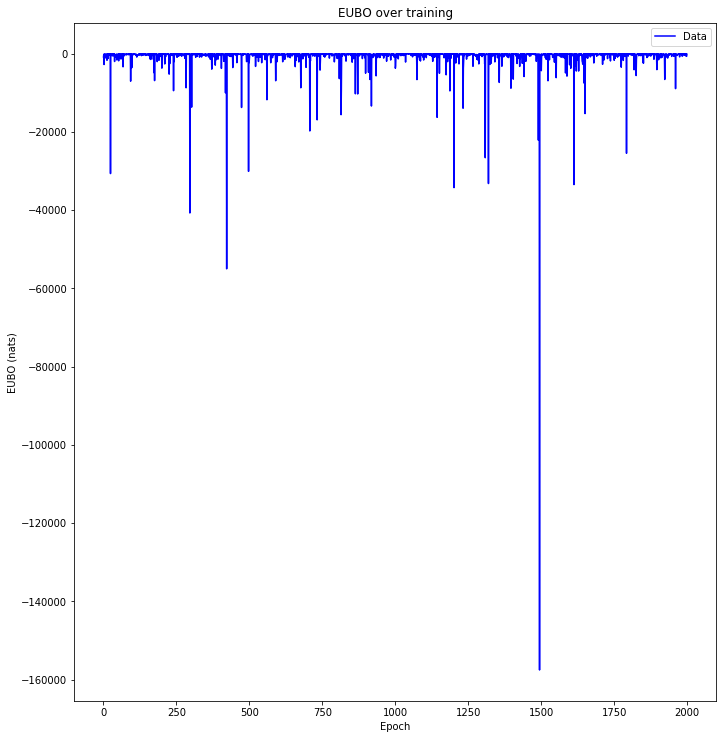

In [20]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    bouncing_ball_smc = generative_model(data, prior_init_params.copy())
    bouncing_ball_proposal = proposal_model(data, variational_init_params.copy())
    importance_sampler = combinators.GuidedConditioning(bouncing_ball_proposal, bouncing_ball_smc)
    
    inference, trained_params, eubos = importance.variational_importance(
        importance_sampler, 2000, data,
        use_cuda=False, lr=1e-1, inclusive_kl=True,
        patience=200,
    )
    utils.plot_evidence_bounds(eubos, False)
    
    bouncing_ball_posterior = posterior_model(data, trained_params, bouncing_ball_proposal.folder.operator)
    (positions, _, A_pred, final_mu, final_cov), inference, _ = bouncing_ball_posterior(data=data)
    As_pred[s] = A_pred.mean(dim=0).detach().numpy()
    final_mus[s] = final_mu.mean(dim=0).detach().numpy()
    final_covs[s] = final_cov.mean(dim=0).detach().numpy()
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory[:, 1:, :].mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Foldable(%d)/BouncingBallStep' % t]['displacement_%d' % (t+1)].value for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_position_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    modal_directions[s] = bouncing_ball.reflect_directions(trained_params['directions']['loc']['loc'].unsqueeze(0)).squeeze(0)
    
    plt.close('all')

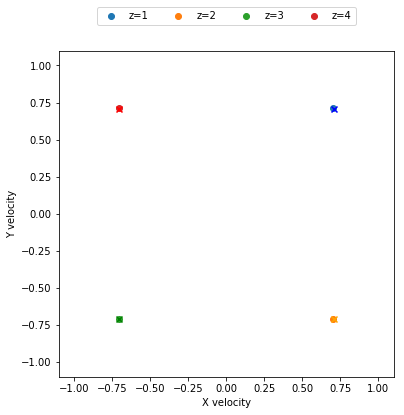

In [21]:
graph_velocity_frequencies(modal_directions.detach())

In [22]:
import bouncing_ball_plots

In [23]:
fs = 3 ## figure size
vmax = 0.3 ## cmap maximum value, to make off-diagonal elements more visible
width_space = 0.05 # space between figures
height_space = 0.05 # space between figures
cov_flag = False # plot the covariances or not
legend_flag = False # plot the legend bar or not
save_flag = True ## save or not

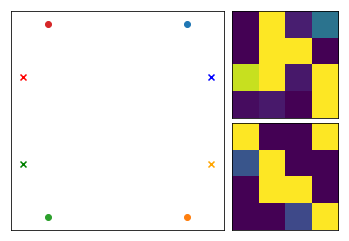

In [24]:
## plot method 1
bouncing_ball_plots.plot_circle_transition(init_v, final_mus, final_covs,
                                           As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

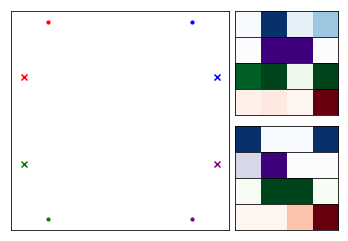

In [25]:
## plot method 2
bouncing_ball_plots.plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [26]:
def plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag):

    As_infer = As_pred / As_pred.sum(-1)[:, :, None]
    As_infer = As_infer.mean(0)
    As_true_ave = As_true.mean(0)

    fig = plt.figure(figsize=(fs*1.5 + width_space,fs + height_space))
    gs1 = gridspec.GridSpec(1, 1)
    # , width_ratios=[2,1], height_ratios=[1,1]
    gs1.update(left=0.0, bottom=0.0, right=(2/3), top=1.0, wspace=width_space, hspace=height_space)
    ax1 = fig.add_subplot(gs1[0])

    # ax3 = fig.add_subplot(gs[1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])

    gs2 = gridspec.GridSpec(4, 1)
    gs2.update(left=2/3 + (1/3)*width_space, bottom=0.5+(1/2)*width_space, right=1.0, top=1.0, wspace=0, hspace=0)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs2[1, 0])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs2[2, 0])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs2[3, 0])
    ax5.set_xticks([])
    ax5.set_yticks([])

    gs3 = gridspec.GridSpec(4, 1)
    gs3.update(left=2/3 + (1/3)*width_space, bottom=0.0, right=1.0, top=0.5 - (1/2)*width_space, wspace=0, hspace=0)
    ax6 = fig.add_subplot(gs3[0, 0])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs3[1, 0])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs3[2, 0])
    ax8.set_xticks([])
    ax8.set_yticks([])
    ax9 = fig.add_subplot(gs3[3, 0])
    ax9.set_xticks([])
    ax9.set_yticks([])
    markersize = 10.0
    colors = ['b', 'Purple', 'g', 'r']
    ## plot left one
    ax1.scatter(init_v[:,0], init_v[:,1], s=markersize, color=colors[0], label='z=1')
    ax1.scatter(init_v[:,0], -init_v[:,1], s=markersize, color=colors[1], label='z=2')
    ax1.scatter(-init_v[:,0], -init_v[:,1], s=markersize, color=colors[2], label='z=3')
    ax1.scatter(-init_v[:,0], init_v[:,1], s=markersize, color=colors[3], label='z=4')

    for k in range(K):
        ax1.scatter(final_mus[:,k,0], final_mus[:,k,1], c=colors[k], marker='x')
    if cov_flag:
        for k in range(K):
            for s in range(num_series):
                plot_cov_ellipse(cov=final_covs[s, k, :, :], pos=final_mus[s, k, :], nstd=0.3, ax=ax1, alpha=0.3)
    #    ax1.set_xlabel('x velocity')
    #    ax1.set_ylabel('y velocity')
    if legend_flag:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15), ncol=4)

    ax2.imshow(As_infer[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax3.imshow(As_infer[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax4.imshow(As_infer[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax5.imshow(As_infer[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    ax6.imshow(As_true_ave[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax7.imshow(As_true_ave[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax8.imshow(As_true_ave[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax9.imshow(As_true_ave[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    if save_flag:
        fig.savefig('combinator_results.pdf', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.svg', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.png', dpi=600, bbox_inches='tight')

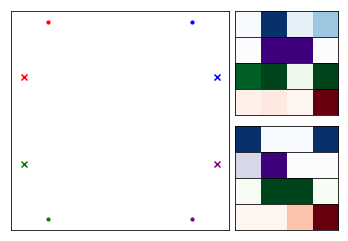

In [27]:
## plot method 2
plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)